In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import datetime as dt
import numpy as np

In [2]:
#Pick a ticker pair

pair = ['GOOGL', 'MSFT']

start = dt.datetime(2015,1,1)
end = dt.datetime.now()

data = yf.download(['GOOGL', 'MSFT'], start, end)['Close']
data.dropna(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [3]:
#Testing for cointegration //NOTE: (Coint function uses augmented Engle-Granger two-step cointegration test.)
#Cointegration valid if P-value < 0.05

from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(data['GOOGL'], data['MSFT'])
print('P-value =', pvalue) 


P-value = 0.013854253357451293


In [4]:
#Computing the spread and Z-score //NOTE: Spread = difference of linear regression, Z-score = normalised distance from mean 
# z > 2 indicates spread is too wide 
# z < -2 indicates spread is too narrow 
# z = 0 spread is normal/mean

spread = data['GOOGL'] - data['MSFT']
zscore = (spread - spread.mean())/spread.std()




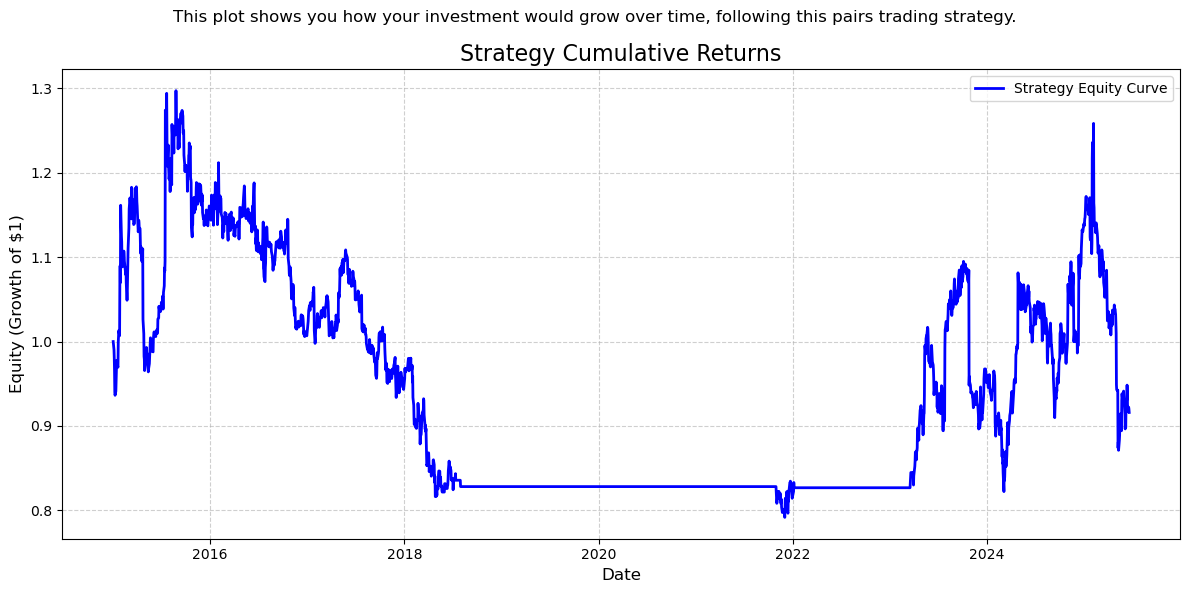

In [33]:
#EXAMPLE - Trading opporunity has arisen, therefore we need to define entry/exit signals

#Trading strategy notes:
#If the spread gets too wide, we aim to short the winnner, long the loser, because a wide spread implies overvaluation relative to other asset due to prolonged diversion form one another.
#Vice-versa, spread gets too narrow, long the winner, short the loser
#Absolute score of 0.2 is desired becuase: 0.05 exits too often, 0.5, more forgiving exits later. (I know my code is contradictory of this, however for the sake of my graph being visual, I wanted to see more of the line as apposed to it being flat at 0.83)


long_entry = zscore < -0.8
short_entry = zscore > 0.8
exit_trade = abs(zscore) < 0.05

#Backtesting Strategy 

positions = pd.DataFrame(index=data.index, columns=['GOOGL', 'MSFT'], data=0)


positions.loc[long_entry, 'GOOGL'] = 1
positions.loc[long_entry, 'MSFT'] = -1

positions.loc[short_entry, 'MSFT'] = -1
positions.loc[short_entry, 'GOOGL'] = 1

positions.loc[exit_trade, ['GOOGL', 'MSFT']] = 0

positions = positions.shift(1).loc[data.index] #avoid lookahead bias and align with when trades are actually executed. e.g., signal generated on Monday is executed on Tuesday.

returns = data.pct_change().loc[positions.index] 

strategy_returns = (positions * returns).sum(axis=1)
strategy_returns = strategy_returns.dropna()

equity = (1 + strategy_returns).cumprod()

#Plot Extras

plt.figure(figsize=(12, 6))  

plt.plot(equity, color='blue', linewidth=2, label='Strategy Equity Curve')

plt.title('Strategy Cumulative Returns', fontsize=16)
plt.ylabel('Equity (Growth of $1)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.suptitle('This plot shows you how your investment would grow over time, following this pairs trading strategy.', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


#Equity curve shows the cumulative return of the trading strategy over time, starting from a base value of 1.0. Each daily strategy return is compounded...
#Flatness in the line demonstrates areas where Google and Microsoft stop cointegrating or havent fit the entry criteria for a trade signal.
